# Unbounded spectral

::::{prf:definition} Fourier transform
The **Fourier transform** of a function $u\in L^2$ is the $L^2$ function

$$
\mathcal{F}[u](k) = \hat{u}(k) = \int_{-\infty}^\infty e^{-ikx}u(x)\, dx, 
$$

defined for $k\in \mathbb{R}$, known as the **wavenumber**. 
::::

This is the *analysis* step. The inverse transform that reconstructs $u$ from $\hat{u}$ is called *synthesis*:

$$
u(x) = \frac{1}{2\pi} \int_{-\infty}^\infty e^{ikx} \hat{u}(k)\, dk. 
$$

## Unbounded grid

If we sample $u$ on the unbounded grid $h\mathbb{Z}$, we lose the ability to distinguish all possible wavenumbers, because

$$
e^{i(k+(2\pi/h))x_j} = e^{ikx_j} \cdot e^{i(2\pi/h)(jh)} = e^{ikx_j} \cdot \left( e^{2\pi i} \right)^j = e^{ikx_j}. 
$$

This effect is called **aliasing**, and it implies that the wavenumber can be restricted to the domain

$$
-\frac{\pi}{h} \le k < \frac{\pi}{h}. 
$$

::::{prf:definition} Semidiscrete Fourier transform
A grid function $v_j$ defined on the unbounded grid $x_j=jh$, has SFT 

$$
\hat{v}(k) = \mathcal{F}_h[v](k) = h \sum_{j=-\infty}^\infty e^{-ikx_j} v_j,
$$

defined for $k\in [-\pi/h,\pi/h)$. The inverse SFT is

$$
v_j = \frac{1}{2\pi} \int_{-\pi/h}^{\pi/h} e^{ikx_j} \hat{v}(k)\, dk. 
$$
::::

This is actually deeply connected to a standard Fourier series. There, a bounded (periodic) function in space implies discrete wavenumbers, whereas here, discretization in space implies boundedness (periodicity) in wavenumber. Fourier analysis has many such dualities.

## Spectral differentiation

The heart of a spectral method is to interpolate the data, differentiate the interpolant, and evaluate on the grid. Interpolation is taken care of by allowing the ISFT to be evaluated at off-grid points:

$$
p(x) = \frac{1}{2\pi} \int_{-\pi/h}^{\pi/h} e^{ikx} \hat{v}(k)\, dk. 
$$

If we now take the continuous transform of $p$, we necessarily get

$$
\hat{p}(k) = \begin{cases}
  \hat{v}(k), & |k| \le \pi/h, \\ 
  0, & \text{otherwise}.
  \end{cases}
$$

We call $p$ the **band-limited interpolant** of the grid function $v$. Now we define spectral differentiation of a grid function $v$ to another grid function $w$ by

1. Find the band-limited interpolant $p(x)$ of $v$. 
2. Set $w_j = p'(x_j)$ for all $j$.

To find our infinite differentiation matrix, we note that column $j$ of a matrix can be found by applying it to the vector that has $1$ in element $j$ and zero elsewhere. To put this another way, we need to differentiate the following grid function.

::::{prf:definition} Grid delta function
$$
\delta_j = \begin{cases}
  1, & j=0, \\ 
  0, & \text{otherwise}.
  \end{cases}
$$
::::

Clearly,

$$
\mathcal{F}_h[\delta](k) = h \sum_{j=-\infty}^\infty e^{-ikx_j} \delta_{j} = h,
$$

constant for all $k$ in the wavenumber band. Its BLI is therefore

$$
S_h(x) = \frac{h}{2\pi} \int_{-\pi/h}^{\pi/h} e^{ikx} \, dk = \frac{\sin(\pi x/h)}{\pi x/h},
$$

a **sinc function**. Thus, column 0 of our infinite differentiation matrix has entries

$$
S'_h(x_j) = \begin{cases}
  0, & j=0, \\ 
  \dfrac{(-1)^j}{jh}, & j \neq 0.
  \end{cases}
$$

This is what we used in the previous section.

## Gibbs phenomenon

We can also exploit the obvious fact that 

$$
v_j = \sum_{m=-\infty}^\infty v_m \delta_{j-m}.
$$

and use linearity to write the band-limited interpolant of $v$ as 

$$
p(x) = \sum_{m=-\infty}^\infty v_m S_h(x-x_m).
$$ 

(Note that shifting $\delta$ to have center at $x_m$ does the same thing to the sinc function.)

In [1]:
using Sugar, SpectralMethodsTrefethen
Sugar.get_source(first(methods(p3))) |> last |> print

function p3(h = 1)
    xmax = 10
    fig = Figure()
    x = -xmax:h:xmax                     # computational grid
    xx = -xmax-h/20:h/10:xmax+h/20       # plotting grid
    funs = [
        (x -> float(x == 0), "discrete delta"),
        (x -> float(abs(x) <= 3), "square wave"),
        (x -> max(0, 1 - abs(x) / 3), "tent function")
    ]
    for (plt, (u,label)) in enumerate(funs)
        ax = Axis(
            fig[plt, 1],
            xticksvisible=false, xticklabelsvisible=false,
            yticks=0:1
        )
        (plt==1) && (ax.title = "Convergence of spectral differentiation")
        v = u.(x)
        scatter!(x, v)
        p = [ sum(v[i] * sinc((ξ - x[i]) / h) for i in eachindex(x)) for ξ in xx ]
        lines!(xx, p)
        limits!(ax, -xmax, xmax, -0.5, 1.5)
        text!(-xmax+2, 1.05, text=label)
    end
    return fig
end

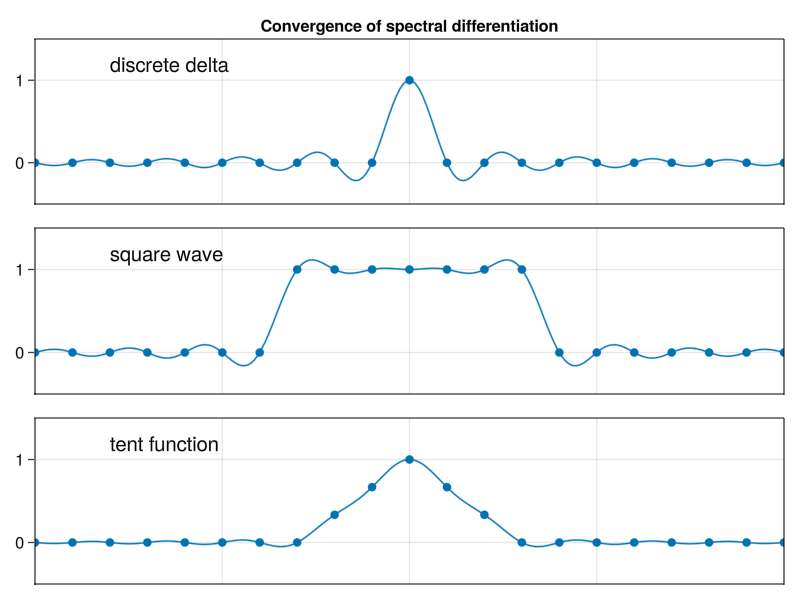

In [2]:
p3()

Note in the middle graph above that the BLI is not a great way to approximate a discrete square wave. In fact, it's worth taking a look at what happens to the square wave as we reduce $h$ for it:

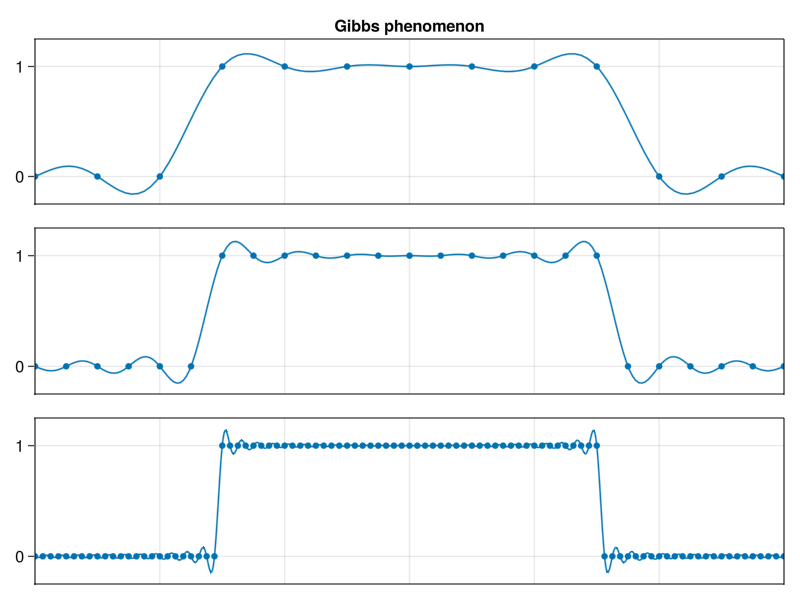

In [3]:
p3g()

The overshoot in the interpolant gets narrower but not shorter, a fact now known as the **Gibbs phenomenon**. One point of view is that we get convergence as $h\to 0 $ in the 2-norm, but not in the $\infty$-norm.


## Higher derivatives

We can use the same process as above to deduce an infinite differentiation matrix for the second derivative. Column 0 is given by

$$
S''_h(x_j) = \begin{cases}
  -\dfrac{\pi^2}{3h^2}, & j=0, \\ 
  2\dfrac{(-1)^{j+1}}{j^2h^2}, & j \neq 0.
  \end{cases}
$$


## Operating in Fourier space

Perhaps the single most attractive feature of the Fourier transform is that differentiation becomes trivial:

$$
\mathcal{F}[u'](k) = ik \,\mathcal{F}[u](k). 
$$

This gives us an important alternative to the interpolation paradigm above for differentiation of the grid function $v$ to get $w$:

1. Set $\hat{w} = i k\, \hat{v}(k)$.
2. Let $w = \mathcal{F}_h^{-1}[\hat{w}]$. 

Due to all the linearity, this gives an equivalent result, but it is a rather different algorithmic path. Sometimes people reserve the term *spectral method* for those that operate within wavenumber space like this, while the version that performs all operations within physical space is *spectral collocation* or (shudder) a *pseudospectral* method.